In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI.ipynb")

# Final Project: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Thursday, December 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = 'https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/'
epa_filenames = pd.read_csv('data/epa_filenames.csv')
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name):
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data=pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

Air quality can be chronic or episodic, leading to distributions similar to log-normal. Maximum AQIs likely occur on days where a particular event produced that bad air quality (whether emissions-based or meteorologically-based). These outliers can affect analyses on the majority of the data. A high (but not extremely-high) percentile of the annual distribution of AQI (like the 90th percentile) represents the top end of the range of AQIs observed in the county that can be associated with long-term, chronic effects.

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
daily_county = epa_data.get('daily_county_aqi')

# Extract month and day from string of dates (convert to datetime first)
daily_county['Month'] = pd.to_datetime(daily_county['Date'], format='%Y-%m-%d').dt.month
daily_county['Day'] = pd.to_datetime(daily_county['Date'], format='%Y-%m-%d').dt.day

daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [7]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [8]:
# !!!!!
# This data (upon import) switches up temp and wind data! Here, switch key and value to get right mapping
# !!!!!
wind_data = epa_data.get('daily_temp').copy()
temp_data = epa_data.get('daily_wind').copy()

epa_data['daily_temp'] = temp_data
epa_data['daily_wind'] = wind_data

# Establish empty dictionary to fill with California-specific daily dataframes from epa_data
epa_data_CA = {}

# Get all dataframes from epa_data and filter them for California data only
for key, value in epa_data.items():
    # Only grab dataframes with 'daily' in their name to ensure daily data
    if 'daily' in key:
        try:
            epa_data_CA[key] = value[value['State Name']=='California'].copy()
        except KeyError:
            # daily_county_aqi data has "State" col instead of "State Name" col
            epa_data_CA[key] = value[value['State']=='California'].copy()

# print(set(epa_data_CA.keys()))
epa_data_CA.get('daily_county_aqi').head()
# print(set(['daily_county_aqi', 'daily_ozone', 'daily_so2',  'daily_co', 'daily_no2', 'daily_temp', 'daily_wind']))

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [9]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [10]:
# Initialize cols for output and temporary df for reading in all lat/long data
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
site_df = pd.DataFrame()


# Several dataframes have multiple columns denoting individual site,
# so build function to create single string values of them
def build_site_code(df, state='State Code', county='County Code', sitenum='Site Num'):
    # Format for concatenating into 'Defining Site'
    df[state+'_str'] = df[state].astype(str).str.zfill(2)
    df[county+'_str'] = df[county].astype(str).str.zfill(3)
    df[sitenum+'_str'] = df[sitenum].astype(str).str.zfill(4)

    # Create string data of unique site ID, and filter for only site ID + lat/long
    df['Defining Site'] = df[state+'_str'] + '-' + df[county+'_str'] + '-' + df[sitenum+'_str']
    
    # Drop created cols
    df = df.drop(columns=[state+'_str', county+'_str', sitenum+'_str'])
    
    return df


# Use aqs_sites as definitive source of site locations
site_df = epa_data['aqs_sites'].copy()
site_df = build_site_code(site_df, sitenum='Site Number')

# Create subset for merging
site_df = site_df[['Defining Site', 'Latitude', 'Longitude']]

#################################################################################################

# Take daily data and match lat/long data by 'Defining Site'
epa_data_CA_merged = epa_data_CA.get('daily_county_aqi').copy()

epa_data_CA_merged = epa_data_CA_merged.merge(site_df, how='left',
                                              left_on='Defining Site', right_on='Defining Site')

# Filter for the correct columns (and ordering)
epa_data_CA_merged = epa_data_CA_merged[cols]
epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217


In [11]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [12]:
# Read in clean copy of traffic data 
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
traffic_data_cleaned = traffic_data.copy()

# Specify which lat/long columns to use (since there are 2 each)
latcol = 'Lat_S_or_W'  # 'Lat_N_or_E', 'Lat_S_or_W'
loncol = 'Lon_S_or_W'  # 'Lon_N_or_E', 'Lon_S_or_W'

# Create dictionary of bad and cleaned values in AADT cols and lat/long cols
replacing_dict = {
    '': 0, 
    'Right Skipped - Input PM on Left Ind. Alignment': np.nan,
    'Left Skipped - Input PM on Right Ind. Alignment': np.nan,
}

# Clean AADT cols and lat/long cols with replacing_dict, and convert to correct dtype
for col in ['Back_AADT','Ahead_AADT', latcol, loncol]: 
    traffic_data_cleaned[col] = traffic_data_cleaned[col].str.strip().replace(replacing_dict).astype(float)

###########################
# Here are two cleaning options for lat/long (due to problems in q6, not sure which is right)
# For bad values from replacing_dict, either remove the nan values, or replace them with the values from the other lat/long combo
# (Since both lat/long combos are very similar, and in many instances the same value)

make_sentinels = True
if make_sentinels:
    # For replacing with other values, generate other column names
    if latcol == 'Lat_S_or_W':
        other_lat = 'Lat_N_or_E'
        other_lon = 'Lon_N_or_E'
    else:
        other_lat = 'Lat_S_or_W'
        other_lon = 'Lon_S_or_W'

    # Replace latcol, loncol nans with data from other_lat, other_lon
    traffic_data_cleaned.loc[pd.isnull(traffic_data_cleaned[latcol]), latcol] = traffic_data_cleaned.loc[pd.isnull(traffic_data_cleaned[latcol]), other_lat]
    traffic_data_cleaned.loc[pd.isnull(traffic_data_cleaned[loncol]), loncol] = traffic_data_cleaned.loc[pd.isnull(traffic_data_cleaned[loncol]), other_lon]

else:
    # Simply remove nan values
    traffic_data_cleaned = traffic_data_cleaned[(pd.notnull(traffic_data_cleaned[latcol])) & 
                                                (pd.notnull(traffic_data_cleaned[loncol]))]

# For general cleaning, make sure they are still floats
traffic_data_cleaned[latcol] = traffic_data_cleaned[latcol].astype(float)
traffic_data_cleaned[loncol] = traffic_data_cleaned[loncol].astype(float)

# Rename lat/long cols to format for desired output
traffic_data_cleaned = traffic_data_cleaned.rename(columns={latcol: 'Latitude', loncol: 'Longitude', })
###########################

# Create final 'AADT' column
traffic_data_cleaned['AADT'] = traffic_data_cleaned['Back_AADT'] + traffic_data_cleaned['Ahead_AADT']
traffic_data_cleaned['AADT'] = traffic_data_cleaned['AADT'].astype(int)

# Get desired column subset
traffic_data_cleaned = traffic_data_cleaned[['District', 'Route', 'County', 'Descriptn',
                                             'AADT', 'Latitude', 'Longitude']]

#traffic_data.head()
traffic_data_cleaned.head()

,District,Route,County,Descriptn,AADT,Latitude,Longitude
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,4000,38.759843,-123.518503
1,1,1,MEN,NORTH LIMITS GUALALA,7100,38.770046,-123.531890
2,1,1,MEN,FISH ROCK ROAD,6200,38.803549,-123.585411
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",4600,38.903973,-123.691513
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",5000,38.910913,-123.692410


In [13]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [14]:
# Source: https://geopandas.org/gallery/create_geopandas_from_pandas.html

# Create quick copies of epa_data_CA_merged, since gpd and buckets func seem to be operating in-place
ca_data = epa_data_CA_merged.copy()

# Initialize GeoDataFrame of traffic data
geo_traffic = gpd.GeoDataFrame(
    traffic_data_cleaned, 
    geometry = gpd.points_from_xy(traffic_data_cleaned['Longitude'], traffic_data_cleaned['Latitude'])
)

# Initialize GeoDataFrame of EPA data
geo_epa = gpd.GeoDataFrame(
    ca_data, 
    geometry = gpd.points_from_xy(ca_data['Longitude'], ca_data['Latitude'])
)

# Join two geo-dataframes
gpd_epa_traffic = gpd.sjoin_nearest(geo_epa, geo_traffic, how='left',) # should save dist with `distance_col='Distance' in actual project


# Clean data by renaming columns and generating subset of columns
gpd_epa_traffic = gpd_epa_traffic.rename(columns={'Latitude_left': 'Site Lat', 'Longitude_left': 'Site Long',
                                                  'Latitude_right': 'Traffic Lat', 'Longitude_right': 'Traffic Long',
                                                 })
gpd_epa_traffic = gpd_epa_traffic[['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 
                                   'Defining Site', 'Site Lat', 'Site Long', 'Traffic Lat', 'Traffic Long', 
                                   'Descriptn', 'AADT']]

# del ca_data # delete quick copy from above
gpd_epa_traffic.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn,AADT
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741,37.866594,-122.303832,"BERKELEY, UNIVERSITY AVENUE",467000
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741,37.866594,-122.303832,"BERKELEY, UNIVERSITY AVENUE",467000
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217,37.700835,-121.773562,NORTH LIVERMORE AVENUE,386700
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217,37.700835,-121.773562,NORTH LIVERMORE AVENUE,386700


In [15]:
grader.check("q2b")

q2b results: All test cases passed!


<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [16]:
# Create function for both Median and Max analyses
def get_aqis(df, func='median', top_n=10):
    # Filter out data from places that are not strictly US states
    not_states = ['Country Of Mexico', 'District Of Columbia', 'Puerto Rico', 'Virgin Islands']

    return (df[~df['State'].isin(not_states)]
            .copy()
            
            .groupby('State')
            .agg({f'{func.title()} AQI': 'mean'}) # Depending on func argument, can select Median or Max
            
            # Clean by ordering values and renaming to desired column name for output
            .sort_values(by=f'{func.title()} AQI', ascending=False)
            .rename(columns={f'{func.title()} AQI': f'Average {func.title()} AQI'})
            .head(top_n) # choose only top number from df (default 10)
            # .round(2)
           )

# Do analysis on annual data
worst_median_aqis = get_aqis(epa_data.get('annual_county_aqi'), func='median')
worst_max_aqis = get_aqis(epa_data.get('annual_county_aqi'), func='max')

# Since the get_aqis() function returns a dataframe, convert to series
worst_median_aqis = worst_median_aqis['Average Median AQI'] # convert df to Series
worst_max_aqis = worst_max_aqis['Average Max AQI'] # convert df to Series

print("Worst Median AQI : \n{}\n".format(worst_median_aqis)) 
print("Worst Max AQI : \n{}".format(worst_max_aqis))

#set(worst_median_aqis.index).intersection(set(worst_max_aqis.index))

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Average Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Average Max AQI, dtype: float64


In [17]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

Arizona, California, Connecticut, and Nevada are in both of the top 10 lists. If the ```worst_median_aqis``` states signify chronic AQI issues and ```worst_max_aqis``` states signify episodic AQI issues, these four states suffer from chronic and episodic air quality issues. The western states (Arizona, California, and Nevada) have strong sunlight which leads to high secondary pollutants like secondary Particulate Matter and ozone (i.e., chronic effects), but also have seen poor air quality from wildfire smoke (i.e., episodic). Connecticut is downwind of New York City which is a chronic source, but the northeast also has interesting meteorology that produces episodic air quality events. 

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [18]:
days_with_AQI = epa_data.get('daily_county_aqi').copy()

# Filter out data from places that are not strictly US states
not_states = ['Country Of Mexico', 'District Of Columbia', 'Puerto Rico', 'Virgin Islands']

days_with_AQI = (days_with_AQI[~days_with_AQI['State Name'].isin(not_states)]
                 
                 # Count the number of days (with one date per row) that a given county reports in daily_county_aqi
                 .groupby(['State Name', 'county Name'])
                 .agg({'Date': 'count'})
                 .reset_index()
                 
                 # Take all the county results and get the average for each state 
                 .groupby('State Name')
                 .agg({'Date': 'mean'})
                 
                # Clean by ordering values and renaming to desired column name for output                 
                 .sort_values(by='Date', ascending=True)
                 .rename(columns={'Date': 'Days with AQI'})
    )

days_with_AQI = days_with_AQI['Days with AQI'] # convert df to Series

days_with_AQI.head()

State Name
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [19]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [20]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [21]:
# Create subset of CA's daily_county_aqi for analysis
ca_aqi_freqs = epa_data_CA.get('daily_county_aqi')[['county Name', 'Date']].copy()

# Convert string Date to datetime Date
ca_aqi_freqs['Date'] = pd.to_datetime(ca_aqi_freqs['Date'], format='%Y-%m-%d')

# Create set of all days in calendar year 2020
days_in_2020 = set(pd.date_range(start='1/1/2020', end='12/31/2020'))

# Create empty dictionary to populate with missing days
county_to_missing_dates = {}

# For each county
for k in ca_aqi_freqs['county Name'].unique():
    
    # Find the set of days reported in ca_aqi_freqs and do a set subtraction to get the
    #  days in 2020 not reported in ca_aqi_freqs
    missing_days = days_in_2020 - set(ca_aqi_freqs.loc[ca_aqi_freqs['county Name']==k, 'Date'])
    
    # If there are missing days in that county
    if len(missing_days) > 0:
        # Add the county to county_to_missing_dates dictionary, with 
        #  key being county name, and value being list of string-formatted Dates
        county_to_missing_dates[k] = list(pd.Series(list(missing_days)).dt.strftime('%Y-%m-%d'))

In [22]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

The most common missing date is February 29, which only occurs in a leap year. The 4th of July also has two counties with missing data, but the first two weeks of July have two counties with missing data as well.

The two counties that have the most missing days are Del Norte (with 92) and Trinity (with 35). These two counties are in the rural northwest of California and may present difficulties in maintaining staffing, power, and connectivity that is required for air quality monitoring stations to continuously report. Trinity county also was one location significantly affected by the August complex fire in 2020, which may have destroyed several air quality monitoring stations.

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


<AxesSubplot:>

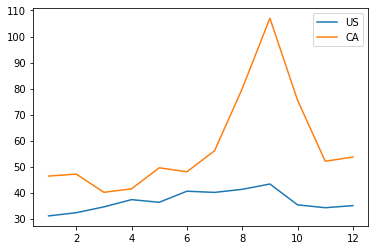

In [23]:
# Get Series of average AQIs nationwide and in CA for each month in 2020 
aqi_per_month = epa_data.get('daily_county_aqi').groupby('Month').agg({'AQI': 'mean'})['AQI']
aqi_per_month_CA = epa_data_CA.get('daily_county_aqi').groupby('Month').agg({'AQI': 'mean'})['AQI']

print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

# Not from skeleton code, but for sake of written questions here is a plot of those Series for comparison
pd.DataFrame({'US': list(aqi_per_month), 'CA': aqi_per_month_CA}, index=range(1,13)).plot()

In [24]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

The fall AQI is substantially higher than the annual trend - this is due to the major wildfires that occurred in 2020. It also is continuously higher than the mean US AQI for any given month, which is in line with the answer from 3a (that California hosted both some of the worst median and max AQIs of any state).

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

$f(x) = \theta_{0} + \theta_{1}sin(x)$ 

$g(x) = \theta_{0} + \theta_{1}sin(x) + \theta_{2}x$

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [25]:
#####################################################
# Old Student Answer
# 
# def bucket_data(table, aggfunc, resolution):
    
#     # Copy and create subset of input dataframe table for analysis
#     table = epa_data_CA_merged[['Latitude', 'Longitude', 'AQI']].copy()
    
#     # Remove any row that has a nan value in it
#     table = table[(pd.notnull(table['Latitude'])) & 
#                   (pd.notnull(table['Longitude'])) & 
#                   (pd.notnull(table['AQI']))]

#     # Create bins for latitude and longitude
#     latbins = np.linspace(table['Latitude'].min(), table['Latitude'].max(), resolution, endpoint=False)
#     lonbins = np.linspace(table['Longitude'].min(), table['Longitude'].max(), resolution, endpoint=False)

#     # Create new columns that are the maximum bin which a given data point is still greater than
#     table['New Latitude'] = table['Latitude'].apply(lambda x: np.max(latbins[x>=latbins]))
#     table['New Longitude'] = table['Longitude'].apply(lambda x: np.max(lonbins[x>=lonbins]))

#     # Clean data for output by renaming columns and rounding to specified resolution
#     table = table.rename(columns={'New Latitude': 'lat_bucket', 'New Longitude': 'long_bucket'})
#     table['lat_bucket'] = np.round(table['lat_bucket'], 2)
#     table['long_bucket'] = np.round(table['long_bucket'], 2) # previously 1

#     # Create pivot table of all table data, binning by lat/long buckets 
#     #  and returning the average AQI in that cell
#     newtable = pd.pivot_table(table,
#                               values='AQI', 
#                               index='lat_bucket', 
#                               columns='long_bucket', 
#                               aggfunc=aggfunc
#                              )

#     return newtable

#####################################################
# Implementing Instructor Answer
def bucket_data(table, aggfunc, resolution):
    table = table.copy()
    lat_buckets = np.sort(np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=False))
    long_buckets = np.sort(np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint=False))
    
    lat_buckets_map = dict(list(zip(lat_buckets, np.around(lat_buckets, decimals=2))))
    long_buckets_map = dict(list(zip(long_buckets, np.around(long_buckets, decimals=2))))
    
    get_lat_bucket_num = lambda loc: lat_buckets_map.get(lat_buckets[lat_buckets <= loc].max())
    get_long_bucket_num = lambda loc: long_buckets_map.get(long_buckets[long_buckets <= loc].max())
    
    table['lat_bucket'] = table['Latitude'].apply(get_lat_bucket_num)
    table['long_bucket'] = table['Longitude'].apply(get_long_bucket_num)
    
    pivot_cols = ['lat_bucket', 'long_bucket', 'AQI']
    return pd.pivot_table(table[pivot_cols], index='lat_bucket', columns='long_bucket', aggfunc=aggfunc)


# Test output from function and compare to the output given in the prompt
# bucket_data(ca_data, np.mean, 5)
bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket    -124.20    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

In [26]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

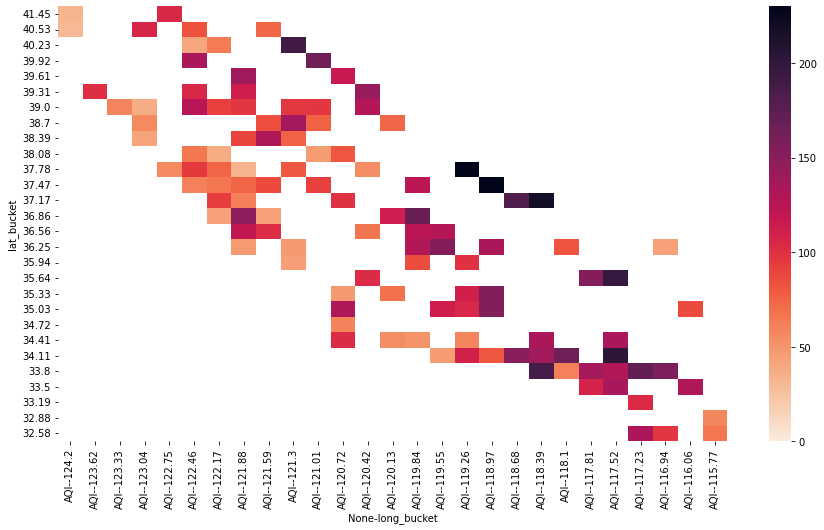

In [27]:
# Use bucket_data() function to generate 2-D array (in dataframe format) to use for plotting a heatmap of AQI in CA
# heatmap_data = bucket_data(ca_data.query('Month == 9'), 'median', 30)
heatmap_data = bucket_data(epa_data_CA_merged.query('Month == 9'), 'median', 30)

# Create visualization (their skeleton code)
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [28]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

The darkened center channel of the heatmap shows the San Joaquin valley which famously has poor air quality due to the highways, agriculture, and moutainous barriers. The bottom of the heatmap is dark over the LA basin, which transports emissions from LA downwind into the southeastern part of the State. The LA basin is one of the most studied areas for emissions due to its continually poor air quality.

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [29]:
####################################################################################
## The goal in this cell is to collate all the individual daily data, and evaluate
## the data for potentially interesting trends
##
## Part 1. Clean 'aqs_sites' for joining with other daily data
####################################################################################

# Create copy of aqs_sites only in California
site_df = epa_data['aqs_sites'].copy()
site_df = site_df.query("`State Name`=='California'")

####################################################################################
####################################################################################
# Create new field for general region of California, determined by County
# Define regions of California by Counties
regions_CA = {
    'North Coast': [ 'Del Norte', 'Humboldt', 'Lake', 'Mendocino', 'Trinity',],
    'Central Coast': ['Alameda', 'Contra Costa', 'Marin', 'Monterey', 'Napa', 'San Benito',
                      'San Francisco', 'San Luis Obispo', 'San Mateo',
                      'Santa Clara', 'Santa Cruz', 'Solano', 'Sonoma',],
    'Southern Coast': ['Los Angeles', 'Orange', 'San Diego', 'Santa Barbara', 'Ventura',],
    'North Central': ['Butte', 'Colusa', 'Glenn', 'Siskiyou', 'Tehama',],
    'Central Valley': ['Fresno', 'Kern', 'Kings', 'Madera', 'Merced', 'Sacramento', 'San Joaquin', 
                       'Stanislaus', 'Sutter', 'Tulare', 'Yolo', 'Yuba'],
    'Northwest Mountains': ['Lassen', 'Modoc', 'Nevada', 'Plumas', 'Shasta', 'Sierra',],
    'Central Mountains': ['Alpine', 'Amador',  'Calaveras', 'El Dorado', 'Inyo', 'Mariposa', 'Mono', 'Placer', 'Tuolumne',],
    'Southern Mountains/Desert': ['Imperial', 'Riverside', 'San Bernardino',],    
}

# Use regions_CA (reversed) to map County Name to new column, Region
site_df['Region'] = site_df['County Name'].replace({i: k for k, v in regions_CA.items() for i in v})


####################################################################################
# Use build_site_code function (defined in earlier response cell) to create "Defining Site"
site_df = build_site_code(site_df, sitenum='Site Number')

# Due to issues below in joining PM data from daily_county_aqi, store each site's Region
d = site_df.reset_index().copy()
d = d[['Defining Site', 'Region']]

# Set "Defining Site" as index for joining/merging AQI data
site_df = site_df.set_index("Defining Site")

####################################################################################
# Get subset of site data
site_df = site_df[['Latitude', 'Longitude', 'Elevation',  'Land Use', 'Location Setting',]]

# Make sure dtypes are optimized --> change strings to categorical
site_df['Land Use'] = site_df['Land Use'].astype('category')
site_df['Location Setting'] = site_df['Location Setting'].astype('category')


####################################################################################
## Part 2. Clean individual (daily) dataframes and join together
## 
## Notes from EDA:
## # daily wind is only with two units and two parameter names
## # so2 and co have two sample durations
## # all have multiple POCs (defined as different measurement methods)
####################################################################################

# Establish columns for subsetting
daily_x_cols = [
    # Indexing --> not needed after creating "Defining Site"
    'State Code', 'County Code', 'Site Num', 'Date Local',  'Parameter Name', 'POC',

    # Qualitative columns for describing measurement
    'Method Name', 'Event Type', 'Sample Duration', 'Pollutant Standard', 'Units of Measure', 
   
    # Quantitative columns of actual measurements
    'Arithmetic Mean', '1st Max Value', '1st Max Hour', 'AQI', 
]

def clean_daily(df):
    """
    Generic cleaning function for each daily dataframe.
    Gets subset of daily data, makes Defining Site, and
    sets the index for joining.
    """
    df = df[daily_x_cols].copy()
    
    df = build_site_code(df)
        
    df = df.set_index(["Defining Site", 'Date Local',  'Parameter Name', 'POC'])
    df = df.drop(columns=['State Code', 'County Code', 'Site Num', 'Method Name'])
    
    return df

# Combine daily data into single dataframe, full_df
full_df = pd.DataFrame()

# For each dataframe in epa_data_CA dictionary
for k, v in epa_data_CA.items():
    # For each df that is not 'daily_county_aqi'
    if 'aqi' not in k:
        # Create clean subset of data
        temp_df = clean_daily(epa_data_CA[k])
        
        # Add temp_df to full_df
        if full_df.shape[0] == 0:
            full_df = temp_df.copy()
        else:
            full_df = pd.concat([full_df, temp_df])

####################################################################################
# Join air quality monitor sites (from Part 1 above) to full_df
full_df = full_df.reset_index()
full_df = full_df.set_index('Defining Site')
full_df = full_df.join(site_df, how='left')

####################################################################################
# General cleaning of full_df dtypes to ensure date is properly formatted
# and string columns are categorical
full_df = full_df.reset_index()

full_df['Date Local'] = pd.to_datetime(full_df['Date Local'], format='%Y-%m-%d')

full_df['Parameter Name'] = full_df['Parameter Name'].astype('category')
full_df['Event Type'] = full_df['Event Type'].astype('category')
full_df['Sample Duration'] = full_df['Sample Duration'].astype('category')
full_df['Pollutant Standard'] = full_df['Pollutant Standard'].astype('category')
full_df['Units of Measure'] = full_df['Units of Measure'].astype('category')
#full_df['method group'] = full_df['method group'].astype('category')

full_df = full_df.set_index(['Defining Site', 'Date Local', 'Parameter Name', 'POC'])

####################################################################################
## Part 3. Clean PM data from 'daily_county_aqi' and join with full_df
## 
## Notes
## # PM should have its own dataframe, but not provided here, so sourcing from
## # 'daily_county_aqi' dataframe
####################################################################################

# Filter 'daily_county_aqi' for only PM data, and get subset of columns
pmcols = ['Date', 'AQI', 'Defining Parameter', 'Defining Site']
daily_pm = epa_data_CA['daily_county_aqi'].loc[(epa_data_CA['daily_county_aqi']['Defining Parameter']=="PM2.5") | 
                                               (epa_data_CA['daily_county_aqi']['Defining Parameter']=="PM10"), 
                                               pmcols].copy()

# Reformat date column to datetime
daily_pm['Date'] = pd.to_datetime(daily_pm['Date'], format='%Y-%m-%d')

####################################################################################
# Clean daily_pm and join with full_df 
# First, rename columns to match full_df index cols
daily_pm = daily_pm.rename(columns={'Date': 'Date Local', 'Defining Parameter': 'Parameter Name'})

# Create POC column and set index for joining
daily_pm['POC'] = 1
daily_pm = daily_pm.set_index(['Defining Site', 'Date Local', 'Parameter Name', 'POC'])

# Join full_df and daily_pm
full_df = full_df = pd.concat([full_df, daily_pm])

####################################################################################
# Create new columns to help with time indexing, based off of 'Date Local'
full_df = full_df.reset_index()
full_df['Month'] = full_df['Date Local'].dt.month
full_df['Day'] = full_df['Date Local'].dt.day
full_df['Week of Year'] = full_df['Date Local'].dt.week

# Since daily_pm lacks Region info, assign it by merging with original data from site_df 
# (stored in d)
full_df = full_df.merge(d, left_on='Defining Site', right_on='Defining Site', how='left') 

full_df = full_df.set_index(['Defining Site', 'Date Local', 'Parameter Name', 'POC'])


####################################################################################
## Part 4. Create analysis dataframes from full_df for insightful visualization
## 
## 4(a). NO2 and O3 are secondary pollutants that are related by chemistry. Their
##       production depends on how "clean" their environment is (i.e., urban vs.
##       rural), so determine their distributions and relationship.
##
## 4(b). The different regions of CA have different air quality issues.
##       Here, bin AQI by region and determine the relative frequency of 
##       the different pollutants over the course of the year.
##       
####################################################################################

# 4(a) - Build subset of ozone and NO2 records by location setting 
#        (originally from 'aqs_sites')
oxidizers = (full_df
             .reset_index()
             .pivot_table(
                 index=['Defining Site', 'Date Local'],
                 columns='Parameter Name',
                 aggfunc={'Arithmetic Mean': 'mean', 'Location Setting': 'first'},
             )
            )

# Get relevant subset from pivot table and rename to eliminate MultiIndexing 
oxidizers = oxidizers[[('Arithmetic Mean', 'Nitrogen dioxide (NO2)'), ('Arithmetic Mean', 'Ozone'), ('Location Setting', 'Ozone')]]
oxidizers.columns = ['Nitrogen dioxide (NO2)', 'Ozone', 'Location Setting']

# Since urban and suburban are very similar for secondary pollutants, 
# bin together for this analysis
oxidizers['Location Setting'] = oxidizers['Location Setting'].replace({'URBAN AND CENTER CITY': 'URBAN', 'SUBURBAN': 'URBAN', 'UNKNOWN': np.nan})

# Convert ozone and NO2 to relevant units for plotting
oxidizers['Ozone'] = oxidizers['Ozone'] * 1000 # to convert from ppm to ppb

oxidizers['Log Nitrogen dioxide (NO2)'] = np.log(oxidizers['Nitrogen dioxide (NO2)'])
# oxidizers['Ozone'] = np.log(oxidizers['Ozone']) # not necessary, reasonably Gaussian

#####################################################################################################
#####################################################################################################
# 4(b) - Build time series of pollutant relative frequencies (as defining parameter for AQI)
#        by region in California
days = (full_df
        .reset_index()
        
        # Get subset of relevant columns
        .loc[:, ['Defining Site', 'Date Local', 'Parameter Name', 'AQI', 'Region', 'Week of Year', 'Month']]
        
        # Sort values by site, date, AQI
        .sort_values(['Defining Site', 'Date Local', 'AQI'], ascending=[True, True, False])
       )

# Since 'Parameter Name' has wind/temp data, remove them as well as all missing AQI data
days = days[(days['AQI'].notnull()) & 
            (days['Parameter Name']!='Outdoor Temperature') &
            (days['Parameter Name']!='Wind Speed - Resultant') &
            (days['Parameter Name']!='Wind Direction - Resultant')
           ]

# Create new column of which pollutant is the one that defines AQI that day,
# defined as the highest daily AQI at each measurement site 
days['Defining AQI'] = days.groupby(['Defining Site', 'Date Local'])['AQI'].apply(lambda x: x == max(x))

# For xlabels in Figure 2 below, build helper column for if the date is the first of the month 
days['Start of Month'] = days['Date Local'].dt.is_month_start

####################################################################################
# Create a new dataframe which counts how many times each pollutant defined AQI
# that week, grouped by Region
# Aggregate Month and Start of Month for xtick plotting in Visualization cell
regions = (days
           .query("`Defining AQI`==True")
           .groupby(['Region', 'Week of Year', 'Parameter Name']) #  'Date Local', 
           .agg({'AQI': 'count', 'Month': 'max', 'Start of Month': 'max'})
          )

# Create a new dataframe similar to regions, but just counts how many observations
# there are for all pollutants (on that day, in that Region)
region_totals = (regions
                 .reset_index()
                 .groupby(['Region', 'Week of Year'])
                 .agg({'AQI': 'sum'}) # where AQI is a count of AQIs
                )

# Merge region_totals with regions to add the additional column of 
# number of total observations
regions = (regions
           .reset_index()
           .set_index(['Region', 'Week of Year'])
           .merge(region_totals, left_index=True, right_index=True, suffixes=('', '_total'))
           .reset_index()
          )

# Use column of times a pollutant defined AQI with new column of total observations
# to calculate frequency (on that day, in that Region)
regions['frac highest'] = regions['AQI'] / regions['AQI_total']

####################################################################################
## Part 5. Show results of this cell
##
## Parameter names of full_df are:
## ['Carbon monoxide',
##  'Nitrogen dioxide (NO2)',
##  'Outdoor Temperature',
##  'Ozone',
##  'PM10',
##  'PM2.5',
##  'Sulfur dioxide',
##  'Wind Direction - Resultant',
##  'Wind Speed - Resultant']
####################################################################################
print('full_df shape: ', full_df.shape)
full_df.head()

full_df shape:  (326258, 17)


Event Type  \
Defining Site Date Local Parameter Name POC              
06-001-0007   2020-01-01 Ozone          1         None   
              2020-01-02 Ozone          1         None   
              2020-01-03 Ozone          1         None   
              2020-01-04 Ozone          1         None   
              2020-01-05 Ozone          1         None   

                                                     Sample Duration  \
Defining Site Date Local Parameter Name POC                            
06-001-0007   2020-01-01 Ozone          1    8-HR RUN AVG BEGIN HOUR   
              2020-01-02 Ozone          1    8-HR RUN AVG BEGIN HOUR   
              2020-01-03 Ozone          1    8-HR RUN AVG BEGIN HOUR   
              2020-01-04 Ozone          1    8-HR RUN AVG BEGIN HOUR   
              2020-01-05 Ozone          1    8-HR RUN AVG BEGIN HOUR   

                                            Pollutant Standard  \
Defining Site Date Local Parameter Name POC                      
06-001-0007   2020-01-01 Ozone          1    Ozone 8-hour 2015   
              2020-01-02 Ozone          1    Ozone 8-hour 2015   
              2020-01-03 Ozone          1    Ozone 8-hour 2015   
              2020-01-04 Ozone          1    Ozone 8-hour 2015   
              2020-01-05 Ozone          1    Ozone 8-hour 2015   

                                              Units of Measure  \
Defining Site Date Local Parameter Name POC                      
06-001-0007   2020-01-01 Ozone          1    Parts per million   
              2020-01-02 Ozone          1    Parts per million   
              2020-01-03 Ozone          1    Parts per million   
              2020-01-04 Ozone          1    Parts per million   
              2020-01-05 Ozone          1    Parts per million   

                                             Arithmetic Mean  1st Max Value  \
Defining Site Date Local Parameter Name POC                                   
06-001-0007   2020-01-01 Ozone          1           0.019471          0.025   
              2020-01-02 Ozone          1           0.007882          0.017   
              2020-01-03 Ozone          1           0.005706          0.013   
              2020-01-04 Ozone          1           0.012647          0.028   
              2020-01-05 Ozone          1           0.015059          0.031   

                                             1st Max Hour   AQI   Latitude  \
Defining Site Date Local Parameter Name POC                                  
06-001-0007   2020-01-01 Ozone          1            10.0  23.0  37.687526   
              2020-01-02 Ozone          1             9.0  16.0  37.687526   
              2020-01-03 Ozone          1             9.0  12.0  37.687526   
              2020-01-04 Ozone          1            10.0  26.0  37.687526   
              2020-01-05 Ozone          1            10.0  29.0  37.687526   

                                              Longitude  Elevation  \
Defining Site Date Local Parameter Name POC                          
06-001-0007   2020-01-01 Ozone          1   -121.784217      137.0   
              2020-01-02 Ozone          1   -121.784217      137.0   
              2020-01-03 Ozone          1   -121.784217      137.0   
              2020-01-04 Ozone          1   -121.784217      137.0   
              2020-01-05 Ozone          1   -121.784217      137.0   

                                               Land Use  \
Defining Site Date Local Parameter Name POC               
06-001-0007   2020-01-01 Ozone          1    COMMERCIAL   
              2020-01-02 Ozone          1    COMMERCIAL   
              2020-01-03 Ozone          1    COMMERCIAL   
              2020-01-04 Ozone          1    COMMERCIAL   
              2020-01-05 Ozone          1    COMMERCIAL   

                                                  Location Setting  Month  \
Defining Site Date Local Parameter Name POC                                 
06-001-0007   2020-01-01 Ozone          1    U

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

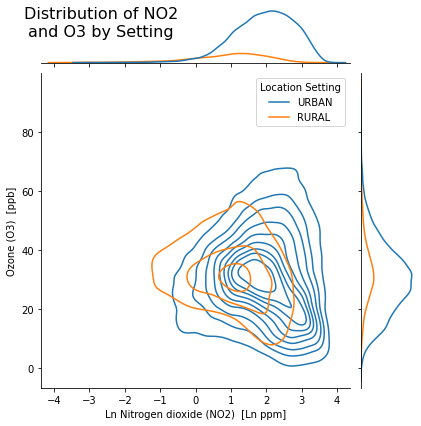

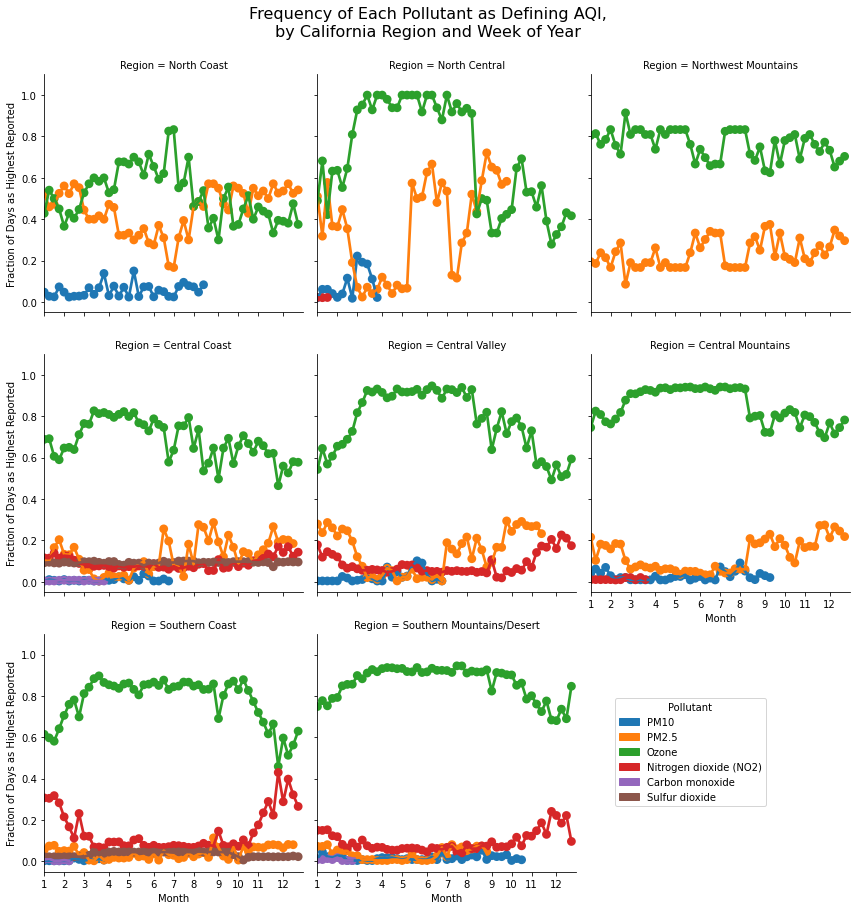

In [30]:
####################################################################################
## Figure 1. Distribution of NO2 and ozone
####################################################################################
g = sns.jointplot(x='Log Nitrogen dioxide (NO2)', y='Ozone', hue='Location Setting', 
                  hue_order=['URBAN', 'RURAL'],
                  data=oxidizers, kind='kde', dropna=True)

g.set_axis_labels('Ln Nitrogen dioxide (NO2)  [Ln ppm]', 'Ozone (O3)  [ppb]')
g.figure.suptitle("Distribution of NO2\nand O3 by Setting", x=0.25, fontsize=16);


####################################################################################
## Figure 2. Time series of pollutant's AQI relative frequency by region
##
## sns.pointplot is used because lineplot and plt.plot will connect any data,
## and therefore plot over missing values, giving the impression that
## data is there.
##
## However, sns.FacetGrid fails to correctly pass patches to matplotlib's legend,
## (see https://gitanswer.com/seaborn-facetgrid-legend-missing-colors-in-key-python-225856735)
## so have to manually create legend using GitAnswer's approach
####################################################################################
import matplotlib.patches as patches

# Initialize FacetGrid
grid = sns.FacetGrid(regions, col='Region', hue='Parameter Name', 
                     
                     col_order = ['North Coast', 'North Central','Northwest Mountains', 
                                  'Central Coast', 'Central Valley', 'Central Mountains', 
                                  'Southern Coast', 'Southern Mountains/Desert',
                                 ],

                     hue_order=['PM10', 'PM2.5', 'Ozone', 'Nitrogen dioxide (NO2)', 'Carbon monoxide', 'Sulfur dioxide'],
                     
                     col_wrap=3, height=4, aspect=1)

# Map pointplot of to FacetGrid
grid.map(sns.pointplot, 'Week of Year', 'frac highest', pallete=sns.color_palette())

# xticks and xticklabels are incorrect in the output, so manually create
# Learned to write FacetGrid xlabels from:
# https://stackoverflow.com/questions/43727278/how-to-set-readable-xticks-in-seaborns-facetgrid
# 
# First, create month labels indexed by week of year
week_month_map = regions.query("`Start of Month`==True").groupby("Week of Year")["Month"].agg("first")

# Then, map these values to xticks
for ax in grid.axes.flat:
    ax_xticks = week_month_map.index.tolist()
    ax_xlabels = week_month_map.values
    
    ax.set_xticks(ax_xticks)
    ax.set_xticklabels(ax_xlabels)

# Manually create index since per GitAnswer post
labels = ['PM10', 'PM2.5', 'Ozone', 'Nitrogen dioxide (NO2)', 'Carbon monoxide', 'Sulfur dioxide']
colors = sns.color_palette().as_hex()[:len(labels)]
handles = [patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]
plt.legend(handles=handles, title='Pollutant', bbox_to_anchor=(1.75, 0.75))

# Declare plot limits and x-, y-labels
grid.set(xlim=(1, 53), ylim=(-0.05, 1.1), 
         xlabel='Month', ylabel='Fraction of Days as Highest Reported')

# Add title
grid.figure.suptitle("Frequency of Each Pollutant as Defining AQI,\nby California Region and Week of Year", 
                     fontsize=16, y=1.05);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

Figure 1. The distribution of ozone is broadly the same in urban and rural environments, while the distribution of NO2 is higher in urban settings. Ozone is centered around approximately 30 ppb for both, while NO2 is centered around ln(2.1) in urban environments and around ln(1.3) in rural environments. Ozone and NO2 are typically regarded as secondary pollutants, meaning that they are formed via photochemical reactions in the atmosphere instead of being directly emitted. Ozone formation depends on the concentration of NO2 and sunlight, but also depends on volatile organic compounds (VOCs, not measured in this dataset). NO2 is typically associated with urban environments, and drives ozone production there; by comparison, VOCs are generally the species that drives ozone production in clean (possibly rural environments). In urban environments, there is an optimal concentration of NO2 to produce the most ozone, and above that concentration NO2 undergoes other reactions that limit ozone production. Figure 1 shows the distribution of measured NO2 and Ozone in California in 2020, as well as the difference between their relationship in urban and rural environments.

Figure 2. Air pollution exists at all scales, but is typically either hyper-local or regional. This figure shows the annual time series of the frequency that a given pollutant was the dominant pollutant, and is broken up by general regions of California. With this figure, several trends become apparent; for example, ozone is typically the most predominant pollutant in all regions, but it is closely related to temperature and is more pronounced in more urban regions. The other five pollutants vary in their relative frequency depending on the region and time of year. Particulate matter is low during the summer but rises during the fall and winter, due to wildfire and woodstove emissions during those times. And finally, it is worth noting that it is common for a pollutant to miss part or all of the time series in a region. This occurs because not every measurement station has instruments that measure each pollutant. Since the air quality index is the worst of the measured pollutants, this dataset could still miss important air quality events due to lack of spatiotemporal resolution of all types of measurements.  

<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

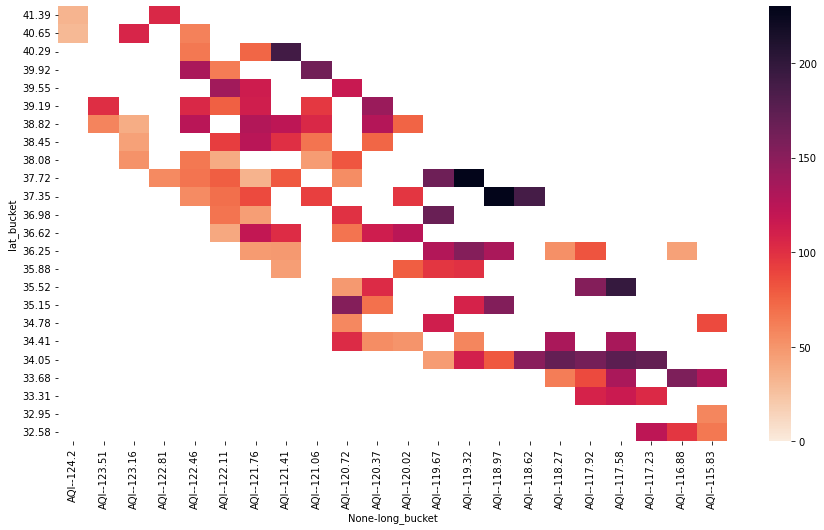

In [31]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [32]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    # pivot_table = pivot_table.copy()
    k_cell = pivot_table.iloc[lat_bucket, lon_bucket]
    
    if pd.notnull(k_cell):
        return k_cell
    else:
        a_arr = pivot_table.iloc[:lat_bucket, lon_bucket].values
        b_arr = pivot_table.iloc[lat_bucket+1:, lon_bucket].values
        l_arr = pivot_table.iloc[lat_bucket, :lon_bucket].values
        r_arr = pivot_table.iloc[lat_bucket, lon_bucket+1:].values
        
        interpolable = sum([any(pd.notnull(i)) for i in [a_arr, b_arr, l_arr, r_arr]]) >= 3

        if not interpolable:
            return np.nan
        else:
            a_val = a_arr[pd.notnull(a_arr)][-1] if sum(pd.notnull(a_arr)) > 0 else np.nan
            b_val = b_arr[pd.notnull(b_arr)][0] if sum(pd.notnull(b_arr)) > 0 else np.nan
            l_val = l_arr[pd.notnull(l_arr)][-1] if sum(pd.notnull(l_arr)) > 0 else np.nan
            r_val = r_arr[pd.notnull(r_arr)][0] if sum(pd.notnull(r_arr)) > 0 else np.nan
            
            return np.nanmean([a_val, b_val, l_val, r_val])
    
np.round(fill_bucket(heatmap_data, 1, 19), 1)

94.8

In [33]:
grader.check("q8a")

q8a results: All test cases passed!

<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

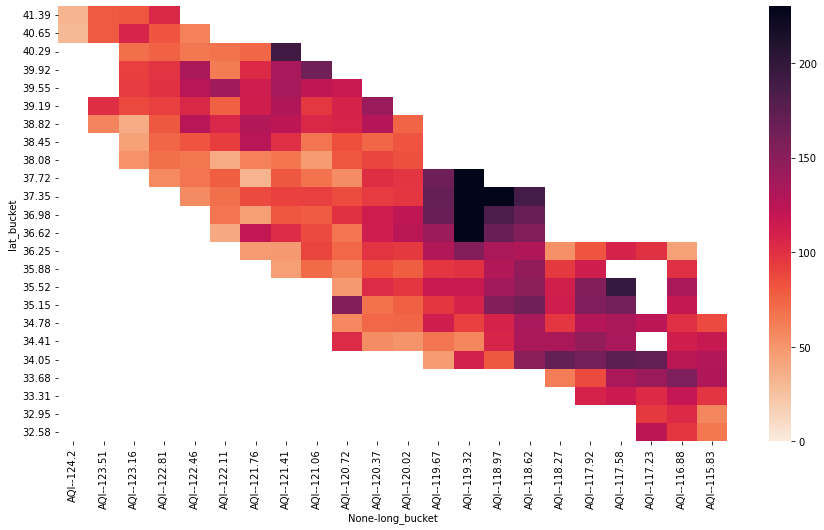

In [34]:
def fill_all(pivot_table):
    pivot_table_new = pivot_table.copy()
    
    cols = list(pivot_table)
    for r, (ind, row) in enumerate(pivot_table.iterrows()):
        for n, col in enumerate(cols):
            if pd.isnull(row[col]):
                pivot_table_new.loc[ind, col] = fill_bucket(pivot_table, r, n)
    
    return pivot_table_new


filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()   


In [35]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

Conduct an inverse-distance-weighted approach to calculate the mean at the ```NaN``` cell. This approach considers data vertically, horizontally, and diagonally related to the ```NaN``` cell. Each of these nearest cells with data are weighted by the inverse of their distance to the ```NaN``` cell, giving an estimate of missing values that is more accurate than a simple linear interpolation.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

$R(\theta) = \frac{1}{n} \sum_{i=0}^{n} (f(y_{i})-f(\hat{y_{i}}))^{2}$

where $f(y) = $ integer level of ordinal category $y$

Loss function determined from [this Piazza post](https://piazza.com/class/kqsiwfz12g0482?cid=1987_f23)

<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

Latitude, Longitude, Month, Day, and Ozone Concentration were chosen from the original notebook data (sourced from epa_data_CA). For the additional data, measurements of California wildfires from 2020 were accessed from the state's [CalFIRE website](https://frap.fire.ca.gov/mapping/gis-data/); the fire's size in acres, as well as the distance between a site and the nearest active fire, were included. A random forest model was chosen due to the nonlinear relationships of space, time, and environmental factors (like ozone and wildfires), even with transformations. As such, AQI Category was chosen as the variable to predict. 

<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

In [36]:
def subset_full_df(df=full_df, data_cols=[], given=[], pollutants={}, index_cols=[]):
    """
    selects subset of full_df, with option to specify index. 
    given and pollutants are lists of filters to apply to full_df.
    given is a generic argument that takes one/many boolean array(s)
    and returns where all are True. pollutants is a list of string 
    pollutants found in full_df['Parameter Name'] and returns all
    matching pollutants.
    """
    if len(given) == 0:
        mask = np.repeat(True, df.shape[0])
    else:
        given = np.array(given)
        mask = given.all(axis=0)
    
    if len(pollutants) != 0:
        pol_mask = np.array([df.reset_index()['Parameter Name']==i for i in pollutants.keys()])
        pol_mask = pol_mask.any(axis=0)
        mask = np.array([mask, pol_mask]).any(axis=0)

    if len(index_cols) > 0: 
        data_cols = data_cols + index_cols
    
    data_subset = (df
                   .copy()
                   .reset_index()
                   .loc[mask, data_cols]
                  )
    
    return data_subset


####################################################################################################
####################################################################################################
def pivot_pollutants(df, index_cols, pivot_dict):
    """
    pivot_dict specifies which metric should be returned for which pollutant.
    pivod_dict takes form of key=pollutant (option from "Parameter Name"),
    value='AQI' or 'Arithmetic Mean'. 
    """
    df = df.copy()
    
    pivot_cols = ['Parameter Name', 'AQI', 'Arithmetic Mean']
    available_pollutants = df['Parameter Name'].unique()
    
    df_wide = (df
               .drop(columns=[i for i in df.columns if i in ['index']+pivot_cols])
               .drop_duplicates()
               .set_index(index_cols)
              )
    
    for k, v in pivot_dict.items():
        if k in available_pollutants:
            s = (df
                 .loc[df['Parameter Name']==k,]
                 .set_index(index_cols)
                 .rename(columns={v: k})
                 .loc[:, k]
                )
            
            df_wide = df_wide.merge(s, left_index=True, right_index=True, how='left')
    
    return df_wide.reset_index()

    
####################################################################################################
####################################################################################################
def source_y_data(df, data_cols, index_cols):
    y_data = df.reset_index()[index_cols+data_cols].copy()
    y_data = y_data.sort_values(by=index_cols, ascending=True)
    return y_data


####################################################################################################
####################################################################################################
def add_site_data(df_y, df_site, df_regions):
    sites = df_site.copy()
    regions = df_regions.copy().set_index('Defining Site')
    sites = sites.join(regions, how='outer')
    
    if 'Latitude' in df_y.columns:
        sites = sites.drop(columns=['Latitude', 'Longitude'])

    df_y = df_y.merge(sites, left_on='Defining Site', right_index=True,
                      how='left', validate='many_to_one')
    
    return df_y


####################################################################################################
####################################################################################################
def add_subset(df_y, df_subset, index_cols, as_int=True):
    if as_int and 'Defining Site' in index_cols:
        df_y['Defining Site'] = [int(''.join(i.split('-'))) for i in df_y['Defining Site']]
        df_subset['Defining Site'] = [int(''.join(i.split('-'))) for i in df_subset['Defining Site']]

        df_y = df_y.merge(df_subset, on=index_cols, how='left')
        
        return df_y

    
####################################################################################################
####################################################################################################
def imputevals(df, impute_cols, group_cols, aggfunc='mean'):
    imputed_vals = df.copy()
    dfnew = df.copy()
    
    imputed_vals = imputed_vals.groupby(group_cols)[impute_cols].agg(aggfunc).reset_index()
    
    for ind, row in imputed_vals.iterrows():
        locs = np.array([dfnew[col]==row[col] for col in group_cols])
        locs = np.all(locs, axis=0)

        dfnew.loc[locs, impute_cols] = imputed_vals.loc[ind, impute_cols].values
    
    for col in impute_cols:
        dfnew[col] = dfnew[col].fillna(dfnew[col].apply(aggfunc))
    
    return dfnew


####################################################################################################
####################################################################################################
## Importing CalFIRE data
def load_fires(path=r'data/fire20_1.gdb'):
    import zipfile
    from pathlib import Path
    import os

    if os.path.exists(path):
        gdf = gpd.read_file(path)
        return gdf
    else:
        zipped_data = zipfile.ZipFile(r'data/fire20_1.zip', 'r')

        unzip_dir = Path('data')
        zipped_data.extractall(unzip_dir)

        print("Extracted Files:")
        for f in unzip_dir.glob("*.gdb"):
            print("\t",f)
            
        gdf = gpd.read_file(path)
        return gdf

    
####################################################################################################
####################################################################################################
def clean_fires(df_geo):
    df_geo = df_geo.copy()
    df_geo = df_geo[df_geo['YEAR_']=='2020']
    df_geo = df_geo[df_geo['GIS_ACRES']>500]

    # frac_reporting(gdf) # only 2 really, so drop them
    df_geo = df_geo[(pd.notnull(df_geo['CONT_DATE'])) & (pd.notnull(df_geo['GIS_ACRES']))]

    df_geo = df_geo[['INC_NUM', 'FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'GIS_ACRES', 'geometry']]

    
    df_geo['ALARM_DATE'] = df_geo['ALARM_DATE'].str.replace("202-", "2020-")
    df_geo['CONT_DATE'] = df_geo['CONT_DATE'].str.replace("202-", "2020-")

    df_geo['ALARM_DATE'] = df_geo['ALARM_DATE'].str.replace("02020", "2020")
    df_geo['CONT_DATE'] = df_geo['CONT_DATE'].str.replace("02020", "2020")

    df_geo['ALARM_DATE'] = pd.to_datetime(df_geo['ALARM_DATE'].str.split('T').str[0], format='%Y-%m-%d')
    df_geo['CONT_DATE'] = pd.to_datetime(df_geo['CONT_DATE'].str.split('T').str[0], format='%Y-%m-%d')
    
    return df_geo


####################################################################################################
####################################################################################################
def eval_fire_activity(df_geo):
    df_geo = df_geo.copy()
    df_geo['Dates Active'] = [pd.date_range(start=i, end=j) for i,j in zip(df_geo['ALARM_DATE'], df_geo['CONT_DATE'])]
    return df_geo


####################################################################################################
####################################################################################################
def add_fires(df_y, df_geo, drop_cols=[]):
    df_y = df_y.copy()
    df_geo = df_geo.copy()
    
    df_y['Date'] = ['2020-'+str(month).zfill(2)+'-'+str(day).zfill(2) for month, day in zip(df_y['Month'], df_y['Day'])]
    
    geo_y_data = pd.DataFrame()
    
    for day in sorted(list(set(df_y['Date']))):
        active_fires = df_geo[[day in i for i in df_geo['Dates Active']]]
    
        if active_fires.shape[0]>0:
            temp_df = df_y[df_y['Date']==day].copy()
    
            temp_geo = gpd.GeoDataFrame(temp_df, 
                                        geometry=gpd.points_from_xy(temp_df['Longitude'], temp_df['Latitude'])
                                       )
    
            if geo_y_data.shape[0]==0:
                geo_y_data = temp_geo.copy()
            else:
                geo_y_data = pd.concat([geo_y_data, 
                                        gpd.sjoin_nearest(temp_geo, active_fires, 
                                                          how='left', distance_col='Distance')
                                       ])
    
    if len(drop_cols) > 0:
        geo_y_data = geo_y_data.drop(columns=drop_cols)
    return geo_y_data


####################################################################################################
####################################################################################################
def impute_geo_y_data(df_geo, impute_cols):
    df_geo = df_geo.copy()
    for col in impute_cols:
        df_geo[col] = df_geo[col].fillna(0)

    return df_geo


####################################################################################################
####################################################################################################
def correct_aqi_categories(df_y, col='Category'):
    df_y[col] = [i.lower() for i in df_y[col]]
    df_y.loc[df_y[col]=='unhealthy for sensitive groups', col] = 'unhealthy sensitive groups'

    return df_y
    

####################################################################################################
####################################################################################################
def frac_reporting(df, showall=False):
    s = df.apply(lambda s: np.round(sum(pd.notnull(s))/df.shape[0], 3))
    if showall:
        return s
    else:
        return s[s!=1]


####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
def feature_engineer(cols={}, pollutants={}, given=[], include_fire_data=True):
    subset_data = subset_full_df(
        df=full_df, 
        data_cols=cols['full_df']['data_cols'], 
        pollutants=pollutants,
        given=given,
        index_cols=cols['full_df']['index_cols'],
    )
    
    subset_data = pivot_pollutants(
        df=subset_data, 
        index_cols=cols['full_df']['index_cols'], 
        pivot_dict=pollutants,
    )
    
    y_data = source_y_data(
        df=epa_data_CA_merged, 
        data_cols=cols['epa_data']['data_cols'], 
        index_cols=cols['epa_data']['index_cols'],
    )

    y_data = add_site_data(
        df_y=y_data, 
        df_site=site_df, 
        df_regions=d,
    )

    data = add_subset(
        df_y=y_data, 
        df_subset=subset_data, 
        index_cols=cols['epa_data']['index_cols'], 
        as_int=True,
    )

    for impute_col in cols['impute'].keys():
        data = imputevals(
            df=data,
            impute_cols=[impute_col],
            group_cols=cols['impute'][impute_col]['groups'],
            aggfunc=cols['impute'][impute_col]['agg'],
        )
    
    if include_fire_data:
        gdf = load_fires('data/fire20_1.gdb')
        gdf = clean_fires(gdf)
        gdf = eval_fire_activity(gdf)

        data = add_fires(
            df_y=data, 
            df_geo=gdf, 
            drop_cols=['index_right', 'INC_NUM', 'FIRE_NAME', 'geometry',
                       'ALARM_DATE', 'CONT_DATE', 'Dates Active', 'Date'],
        )

        data = impute_geo_y_data(
            df_geo=data, 
            impute_cols=cols['fires']['data_cols'],
        )
    
    if 'Category' in list(data):
        data = correct_aqi_categories(data, col='Category')
    
    return data



####################################################################################################
####################################################################################################
def build_features(df, y_col, x_cols=[]):
    targets = df[y_col].values
    
    if isinstance(targets[0], str):
        targets = np.array([i.lower() for i in targets])
    
    if len(x_cols)==0:
        features = df[[i for i in df.columns if i not in ['AQI', 'Category']]]
    else:
        features = df[x_cols]
    
    return targets, features

####################################################################################################
####################################################################################################
cols = {
    'full_df': {'data_cols': ['Parameter Name', 'Arithmetic Mean', 'Month', 'Day', 'Week of Year'],
                'index_cols': ['Defining Site', 'Date Local']},
    
    'epa_data': {'data_cols': ['AQI', 'Category', 'Latitude', 'Longitude'],
                 'index_cols': ['Defining Site', 'Month', 'Day']},
    
    'impute': {'Ozone': {'groups': ['Region', 'Month'],
                         'agg': 'mean'},
               'Week of Year': {'groups': ['Month', 'Day'],
                                'agg': 'mean'}},
    
    'fires': {'data_cols': ['GIS_ACRES', 'Distance']},
}
            
pollutants_q10 = {
    'Ozone': 'Arithmetic Mean',
}

# !!! Comment out 'GIS_ACRES', 'Distance' when submitting (and set include_fire_data=False)
output_cols = ['Latitude', 'Longitude', 'Month', 'Day', 'Ozone']#, 'GIS_ACRES', 'Distance']


targets, features = build_features(df=feature_engineer(cols=cols, 
                                                       pollutants=pollutants_q10, 
                                                       include_fire_data=False), # set to True for loading external dataset 
                                   y_col='Category',
                                   x_cols=output_cols,
                                  )

features

,Latitude,Longitude,Month,Day,Ozone,GIS_ACRES,Distance
52,37.687526,-121.784217,5,31,0.031579,0.00000,0.000000
513,38.342606,-120.764426,5,31,0.039848,0.00000,0.000000
825,39.708454,-121.617309,5,31,0.035281,0.00000,0.000000
1242,38.201850,-120.680277,5,31,0.039848,0.00000,0.000000
1633,39.189190,-121.998870,5,31,0.035281,0.00000,0.000000
...,...,...,...,...,...,...,...
17760,40.734750,-122.941200,12,31,0.019617,170647.84375,210739.667989
18025,36.332179,-119.291228,12,31,0.014465,170647.84375,210734.038317
18493,37.981780,-120.378551,12,31,0.021231,170647.84375,210736.009551
18518,34.210169,-118.870509,12,31,0.020079,170647.84375,210731.984603


In [37]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [38]:
## Random Forest model
from sklearn import ensemble

def build_model(features, targets):
    rf_model = ensemble.RandomForestClassifier(random_state=42, n_estimators=20)
    rf_model.fit(features, targets)
    return rf_model

In [39]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [40]:
# Declare categories for autograder and predict
categories = [
    "good", "moderate", "unhealthy sensitive groups", 
    "unhealthy", "very unhealthy", "hazardous"
]

def predict(model, features):
    return model.predict(features)

predict(build_model(features, targets), features)

array(['good', 'good', 'good', ..., 'good', 'moderate', 'good'],
      dtype='<U26')

In [41]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [42]:
from sklearn.model_selection import train_test_split

####################################################################################################
####################################################################################################
def model_loss(y, yhat):
    """
    For cv model error. Learned from Piazza post at:
    https://piazza.com/class/kqsiwfz12g0482?cid=1987_f23
    """
    
    loss_scores = {
        "good": 1,  
        "moderate": 2,  
        "unhealthy sensitive groups": 3,  
        "unhealthy": 4, 
        "very unhealthy": 5,  
        "hazardous": 6
    }
    
    y_scores = np.array([loss_scores[i] for i in y])
    yhat_scores = np.array([loss_scores[i] for i in yhat])
    residuals = (y_scores - yhat_scores) ** 2
    
    return np.mean(residuals)


####################################################################################################
####################################################################################################
X_train, X_validation, Y_train, Y_validation = train_test_split(features,
                                                                targets, 
                                                                test_size=0.30, 
                                                                random_state=33)

####################################################################################################
aqi_model = build_model(X_train, Y_train)
Y_predicted = predict(aqi_model, X_validation)

####################################################################################################
binary_error = 1 - aqi_model.score(X_validation, Y_validation)
cv_error = model_loss(Y_validation, Y_predicted)

print(f'binary error: {np.round(binary_error,4)}\ncv error: {np.round(cv_error,4)}\n')
print('(binary error must be less than 0.3)')

binary error: 0.2633
cv error: 0.3515

(binary error must be less than 0.3)


In [43]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

Training R²:        0.2315
Training RMSE:     26.5456
Validation RMSE:   26.5927
5-Fold Mean RMSE:  26.5493

Intercept: 71.672
Coefficients:
 	 Ozone                   10.7607 
 	 Nitrogen dioxide (NO2)   6.0499 
 	 Outdoor Temperature      3.6373 



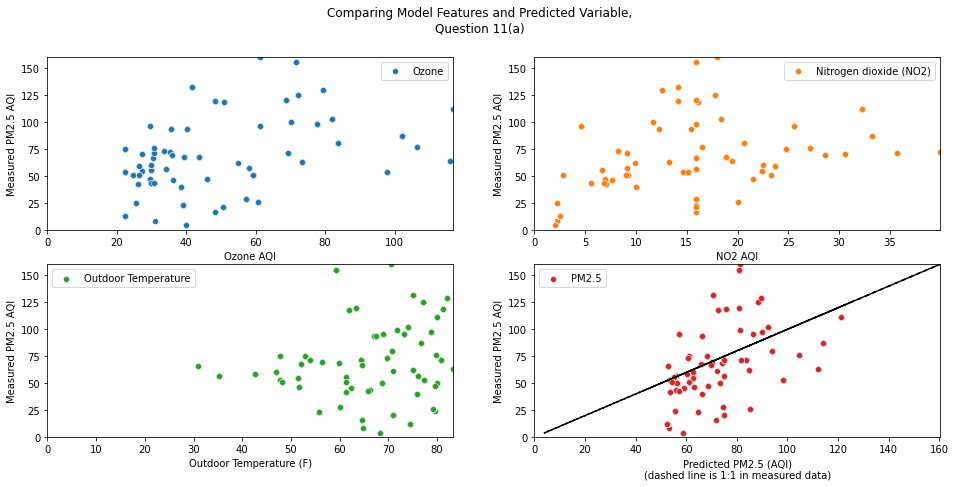

In [44]:
####################################################################################
## The goal in this cell is to use the feature engineering functions defined
## in Question 10 to select three features to predict the AQI related to PM2.5.
## The features chosen for 11a are O3, NO2, and Temperature.
##
## Part 1. Import relevant classes and functions from sklearn.
####################################################################################
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge


####################################################################################
## Part 2(a). Create a feature engineered subset of full_df (from Question 7a),
## using the function series written for Question 10.
####################################################################################
# Declare columns to be used in building the design matrix in Question 11
cols_11 = {
    'full_df': {'data_cols': ['Month', 'Day', 'Week of Year', 
                              'Parameter Name', 'AQI', 'Arithmetic Mean'],
                'index_cols': ['Defining Site', 'Date Local']},
    
    'epa_data': {'data_cols': ['Latitude', 'Longitude'], # will include Region in site join
                 'index_cols': ['Defining Site', 'Month', 'Day']},
    
    # 'fires': {'data_cols': ['GIS_ACRES', 'Distance']},
}

# Declare the pollutants (and units) to include in the design matrix
pollutants_q11 = {
    'Ozone': 'AQI',
    'Nitrogen dioxide (NO2)': 'AQI',
    'PM2.5': 'AQI',
    'Carbon monoxide': 'AQI',
    'Outdoor Temperature': 'Arithmetic Mean',
    'Wind Speed - Resultant': 'Arithmetic Mean',
    'Wind Direction - Resultant': 'Arithmetic Mean',    
}

# Declare all pollutants should get the same space- and time-relevant imputing method
impute_dict = {'groups': ['Region', 'Month'], 'agg': 'mean'}
cols_11['impute'] = {k: impute_dict for k in pollutants_q11.keys()}

# Declare filters to apply to full_df
#  Filter for only sites and dates that report PM2.5 
valid_sites_q11a = full_df.index.get_level_values(0)[full_df.index.get_level_values(2)=='PM2.5'].values
valid_dates_q11a = full_df.index.get_level_values(1)[full_df.index.get_level_values(2)=='PM2.5'].values

given_q11a = [full_df.index.get_level_values(0).isin(valid_sites_q11a),
              full_df.index.get_level_values(1).isin(valid_dates_q11a),
             ]

# Feature engineer data for Question 11
# !!! Comment out 'GIS_ACRES', 'Distance' when submitting (and set include_fire_data=False)
df11 = feature_engineer(cols=cols_11, pollutants=pollutants_q11, given=given_q11a, include_fire_data=False) # set to True for loading external dataset

# To limit RAM usage, convert string column to category
df11['Region'] = df11['Region'].astype('category')

# Impute Land Use
df11['Land Use'] = df11['Land Use'].fillna('UNKNOWN')


####################################################################################
## Part 2(b). Create the design matrix as a subset from the feature engineered
## dataset, and split the matrix into training and testing components.
####################################################################################
# Split data into training, validation, and testing components
train_val_q11a, test_q11a = train_test_split(df11, test_size=0.1, random_state=33)
train_q11a, val_q11a = train_test_split(train_val_q11a, test_size=0.2, random_state=34)

# Declare the 3 features to use in Question 11(a)
output_cols_q11a = ['Ozone', 'Nitrogen dioxide (NO2)', 'Outdoor Temperature']

# Subset and separate the model inputs from the training dataset
targets_q11a, features_q11a = build_features(train_q11a, y_col='PM2.5', x_cols=output_cols_q11a)
targets_q11a_val, features_q11a_val = build_features(val_q11a, y_col='PM2.5', x_cols=output_cols_q11a)


####################################################################################
## Part 3. Create the Ridge Regression model using the chosen features.
####################################################################################
# Instantiate Ridge Regression Model with alpha=0.5
# Copied from Lecture 18 Notebook (Part 2. Regularization)
ridge_model_q11a = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), output_cols_q11a)
    ])),
    ("LinearModel", Ridge(alpha=0.5))
])

# Fit the data to the model
ridge_model_q11a.fit(features_q11a, targets_q11a)


####################################################################################
## Part 4. Evaluate the Ridge Regression model using the chosen features.
## This section was largely copied from Lecture 18 Notebook 
## (Part 2. Regularization).
####################################################################################
# Define RMSE function
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

# Calculate training accuracy and print out to notebook
training_score_q11a = ridge_model_q11a.score(features_q11a, targets_q11a)
# Superscript learned from James' answer at: https://stackoverflow.com/questions/8651361/how-do-you-print-superscript-in-python
print("Training R\u00b2:       ", np.round(training_score_q11a, 4))

# Calculate RMSE for the training and validation data 
# (i.e., 5-fold cross-validation) and print out to notebook
errors_q11a = cross_val_score(ridge_model_q11a, features_q11a, targets_q11a, scoring=rmse_score, cv=5)
mean_error_q11a = np.mean(errors_q11a)
print("Training RMSE:    ", np.round(rmse_score(ridge_model_q11a, features_q11a, targets_q11a), 4))
print("Validation RMSE:  ", np.round(rmse_score(ridge_model_q11a, features_q11a_val, targets_q11a_val), 4))
print("5-Fold Mean RMSE: ", np.round(mean_error_q11a, 4))

# Print out the model's coefficients 
print()
print('Intercept:', np.round(ridge_model_q11a['LinearModel'].intercept_,4))
print('Coefficients:\n',
      '\t', features_q11a.columns[0], '                 ', np.round(ridge_model_q11a['LinearModel'].coef_,4)[0], '\n',
      '\t', features_q11a.columns[1], ' ', np.round(ridge_model_q11a['LinearModel'].coef_,4)[1], '\n',
      '\t', features_q11a.columns[2], '    ', np.round(ridge_model_q11a['LinearModel'].coef_,4)[2], '\n')


####################################################################################
## Part 5. Produce plots to show model results
####################################################################################
# Create mask of randomly drawn row numbers for consistent subsetting
inds = np.random.choice(np.array(range(targets_q11a.shape[0])), size=2000)
mask = np.isin(np.array(range(targets_q11a.shape[0])), inds)

# Declare features for plotting
q11a_cols = ['Ozone', 'Nitrogen dioxide (NO2)', 'Outdoor Temperature', 'PM2.5']

# Randomly subsample the measured predicted variable 
y = targets_q11a[mask]

# Plot the features against the predicted response variable
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,7))

for i, col in enumerate(q11a_cols):
    # Specify which features to plot (using same mask subset)
    if col=='PM2.5':
        x = ridge_model_q11a.predict(features_q11a)[mask]
    else:
        x = features_q11a[mask][col]
    
    # Determine plotting axes indices
    xind = int(np.floor(i/2))
    yind= i - (xind*2)

    sns.scatterplot(x=x, y=y,
                    color=sns.color_palette()[i],
                    label=col, ax=ax[xind,yind])
    
    # Apply formatting
    ax[xind, yind].set_ylabel('Measured PM2.5 AQI')
    if col=='PM2.5':
        ax[xind, yind].set_xlim(0, np.nanmax([x,y]))
        ax[xind, yind].set_ylim(0, np.nanmax([x,y]))
    else:
        ax[xind, yind].set_xlim(0, np.nanmax(x))
        ax[xind, yind].set_ylim(0, np.nanmax(y))
    
# Apply formatting
ax[0, 0].set_xlabel('Ozone AQI')
ax[0, 1].set_xlabel('NO2 AQI')
ax[1, 0].set_xlabel('Outdoor Temperature (F)')
ax[1, 1].set_xlabel('Predicted PM2.5 (AQI)\n(dashed line is 1:1 in measured data)')
ax[1, 1].plot(targets_q11a, targets_q11a, color='black', linestyle='--')
plt.suptitle('Comparing Model Features and Predicted Variable,\nQuestion 11(a)');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

A ridge regression model (linear model with L2 regularization) with 5-fold cross-validation was used to predict PM2.5 AQI with three features: Ozone AQI, Nitrogen Dioxide AQI, and Outdoor Temperature. No transformations were performed, and each feature (including PM2.5 AQI) was imputed as the average value of the entire `Defining Site`'s `Region` for that given `Month`. The training $R^{2}$ was 0.2315, meaning that the model only predicted about 23.1% of the variance in the reported PM2.5 AQI. This model was not overfitted, as the training RMSE was 26.5456 while the validation RMSE was 26.5927 and the 5-fold cross-validation average RMSE was 26.5493.

Considering the figure above and the coefficients from the fitted model, it appears that Ozone has the strongest correlation with PM2.5. Nitrogen Dioxide and Outdoor Temperature have weaker correlations with PM2.5. Outdoor Temperature shows a clear sign of heteroskedasticity (uneven variance). 
The plot of measured vs. predicted PM2.5 AQI does not show any noticeable bias in the residuals, but it has more points below the `y=x` line than above, suggesting the potential utlity of a log-transform.

Finally, this model did not consider several important features that could prove useful for improvement. Spatial or temporal features could encode context around PM2.5 AQI levels. In addition, additional features such as Carbon Monoxide, Wind Speed, and the CalFIRE data could hold some preditive power.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

Training R²:       0.5693
Training RMSE:     0.3016
Validation RMSE:   0.3044
5-Fold Mean RMSE:  0.3022

Ridge Intercept and Coefficients:
                        feature  Ridge estimate
0                     sin Month          0.2083
1                 poly Latitude          0.0188
2                poly Longitude         -0.0616
3                        log O3          0.0844
4                       log NO2          0.0318
5                        log CO          0.1036
6        Wind Speed - Resultant         -0.0290
7   log poly inv-weighted fires         -0.0257
8                  AGRICULTURAL          0.1470
9                    COMMERCIAL          0.0765
10                       DESERT         -0.2989
11                       FOREST          0.0427
12                   INDUSTRIAL          0.0309
13         MILITARY RESERVATION         -0.1258
14                       MOBILE         -0.0580
15                  RESIDENTIAL          0.0411
16                      UNKNOWN          0.14

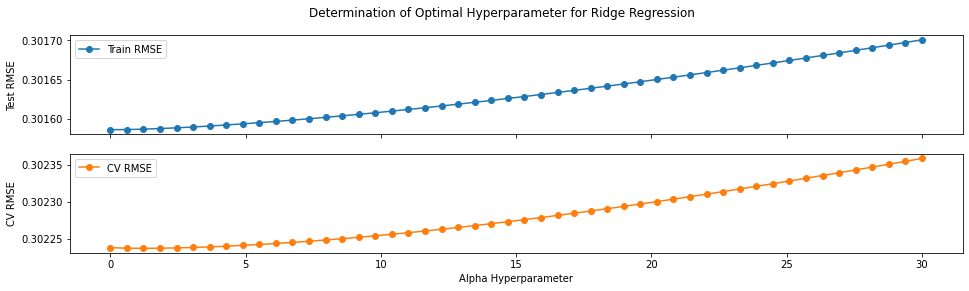

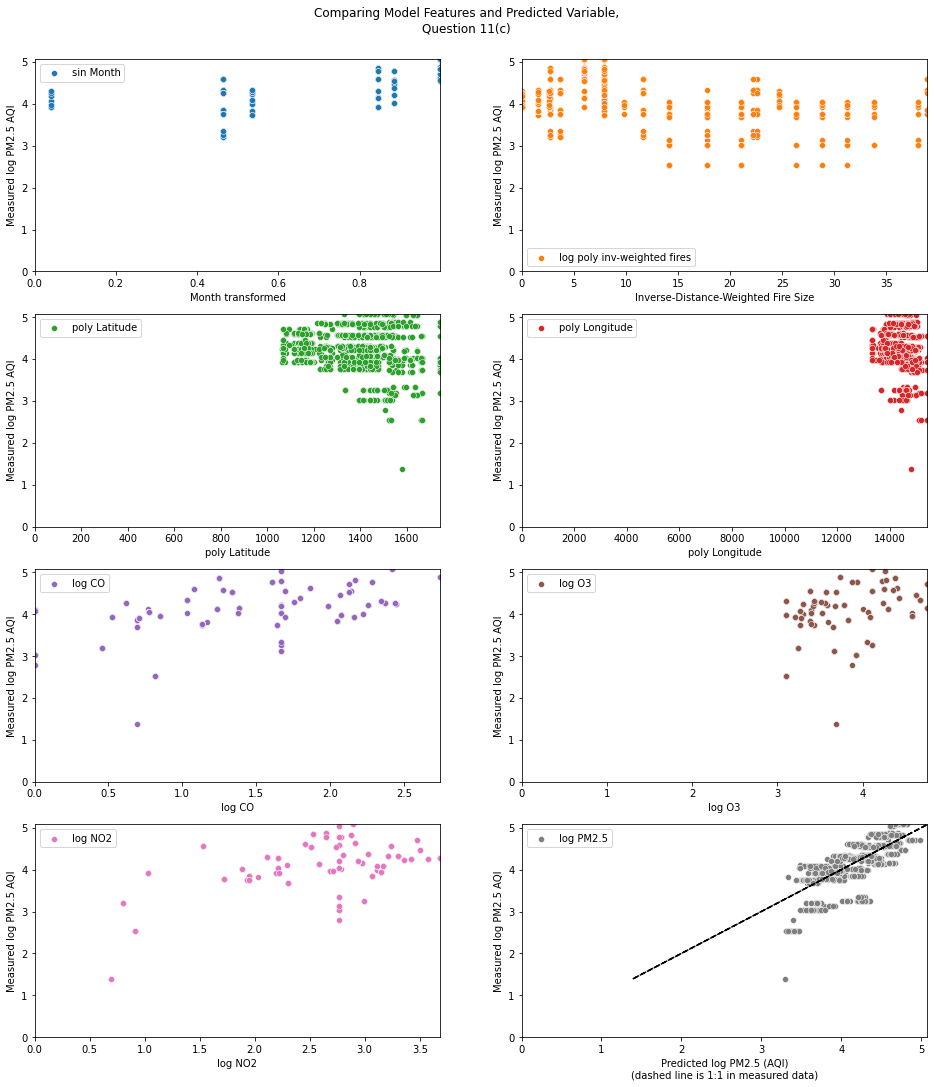

In [45]:
####################################################################################
## Part 1(a). Perform EDA to understand necessary transforms for optimizing
## model from Question 11(a).
## 
## This approach utilized sns.pairplot() and sns.violinplot() to evaluate columns 
## and potentia; transforms. For simplicity of notebook and to avoid restarting 
## kernel, these plots are not executed here.
####################################################################################
# Assess columns to be used in building the design matrix in Question 11(c)
# train_q11['PM2.5'] = targets_q11a
# train_q11['log PM2.5'] = np.log(train_q11['PM2.5'])
# numcols = [
#     'PM2.5', 'log PM2.5',
#     'Month', 'Latitude', 'Longitude', 
#     'Week of Year', 'Carbon monoxide', 'Wind Speed - Resultant',
#     'GIS_ACRES', 'Distance',
# ]
# sns.pairplot(train_q11[numcols])
# sns.violinplot(x=train_q11['Land Use'], train_q11['log PM2.5'])
# sns.violinplot(x=train_q11['Location Setting'], train_q11['log PM2.5'])
# sns.violinplot(x=train_q11['Region'], train_q11['log PM2.5'])


####################################################################################
## Part 1(b). Perform transforms to optimize model from Question 11(a).
##
## Based on EDA of categorical columns, 'Land Use' will be used as location
## is already encoded in Latitude and Longitude (which will be used), and
## 'Location Setting' does not provide sufficient difference in distributions
## of PM2.5 AQI.
####################################################################################
# Calculate inverse-distance-weighted fire acreage from CalFIRE data
# and apply transform
# df11['inv-weighted fires'] = df11['GIS_ACRES'] / df11['Distance']
# df11['log inv-weighted fires'] = np.log(df11['inv-weighted fires'])
# df11['log poly inv-weighted fires'] = df11['log inv-weighted fires']**2

# Apply sinusoidal transform to Months
#  (determined through iterative approach in EDA)
df11['sin Month'] = np.sin((2*np.pi/12)*df11['Month']+3.1)

# Apply log transforms to air pollutants
df11['log PM2.5'] = np.log(df11['PM2.5'])
df11['log CO'] = np.log(df11['Carbon monoxide'])
df11['log O3'] = np.log(df11['Ozone'])
df11['log NO2'] = np.log(df11['Nitrogen dioxide (NO2)'])

# Apply quadratic transform to Latitude and Longitude
df11['poly Latitude'] = df11['Latitude']**2
df11['poly Longitude'] = df11['Longitude']**2

# Drop columns from df11 not used in Question 11(a) or 11(c)
df11 = df11.drop(columns=['Defining Site', 'Month', 'Day', 'Latitude', 'Longitude', 
                          'Elevation', 'Location Setting', 'Region', 'Date Local', 
                          'Week of Year', 'Carbon monoxide', 'Outdoor Temperature', 
                          'Wind Direction - Resultant', 
                          # 'inv-weighted fires', 'log inv-weighted fires', 
                          ])


####################################################################################
## Part 2. Create the design matrix as a subset from the feature engineered
## dataset, and split the matrix into training and testing components.
####################################################################################
# Declare features to use in Question 11(c) model
col_subset_11c = [
    'sin Month', 'poly Latitude', 'poly Longitude', 
    'log O3', 'log NO2', 'log CO',
    'Wind Speed - Resultant', 
    # 'log poly inv-weighted fires', 
    'Land Use', 
]
quant_cols_11c = [i for i in col_subset_11c if i!="Land Use"]

# Split data into training and testing components
train_val_q11c, test_q11c = train_test_split(df11[['log PM2.5']+col_subset_11c], test_size=0.1, random_state=33)
train_q11c, val_q11c = train_test_split(train_val_q11c, test_size=0.2, random_state=34)

# Subset and separate the model inputs from the training dataset
targets_q11c, features_q11c = build_features(train_q11c, y_col='log PM2.5', x_cols=col_subset_11c)
targets_q11c_val, features_q11c_val = build_features(val_q11c, y_col='log PM2.5', x_cols=col_subset_11c)


####################################################################################
## Part 3. Create the new Ridge Regression model using the chosen features. This
## time, "Land Use" will be One Hot Encoded.
####################################################################################
from sklearn.preprocessing import OneHotEncoder

# Instantiate Ridge Regression Model with alpha=0.5
# Copied from Lecture 18 Notebook (Part 2. Regularization)
ridge_model_q11c = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quant_cols_11c),
        ("setting_encoder", OneHotEncoder(), ["Land Use"]),
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", Ridge(alpha=0.5))
])

# Fit the data to the model
ridge_model_q11c.fit(features_q11c, targets_q11c) 


####################################################################################
## Part 4(a). Evaluate the new Ridge Regression model using the chosen 
## features.
## This section was largely copied from Lecture 18 Notebook 
## (Part 2. Regularization).
####################################################################################
# # Calculate training accuracy and print out to notebook
training_score_q11c = ridge_model_q11c.score(features_q11c, targets_q11c)
# Superscript learned from James' answer at: https://stackoverflow.com/questions/8651361/how-do-you-print-superscript-in-python
print("Training R\u00b2:      ", np.round(training_score_q11c, 4))

# Calculate RMSE for the training and validation data 
# (i.e., 5-fold cross-validation) and print out to notebook
errors_q11c = cross_val_score(ridge_model_q11c, features_q11c, targets_q11c, scoring=rmse_score, cv=5)
mean_error_q11c = np.mean(errors_q11c)
print("Training RMSE:    ", np.round(rmse_score(ridge_model_q11c, features_q11c, targets_q11c), 4))
print("Validation RMSE:  ", np.round(rmse_score(ridge_model_q11c, features_q11c_val, targets_q11c_val), 4))
print("5-Fold Mean RMSE: ", np.round(mean_error_q11c, 4))

# Create list of all columns in feature-engineered dataframe
cols_q11c = [i for i in col_subset_11c if i!="Land Use"]
grps_q11c = list(ridge_model_q11c['SelectColumns'].named_transformers_['setting_encoder'].categories_[0])
allcols_q11c = cols_q11c + grps_q11c

# Create dataframe of coefficients
allcol_estimates_q11c = pd.DataFrame({
    'feature': allcols_q11c,
    'Ridge estimate': np.round(ridge_model_q11c['LinearModel'].coef_, 4)
})

# Add intercept to coefficients dataframe
allcol_estimates_q11c2 = pd.concat([
    allcol_estimates_q11c, 
    pd.DataFrame({'feature':'intercept', 
                  'Ridge estimate': np.round(ridge_model_q11c['LinearModel'].intercept_, 4)}, 
                 index=[99])], 
    axis=0)

# Print out the model's intercept and coefficients
print()
print('Ridge Intercept and Coefficients:')
print(allcol_estimates_q11c)


####################################################################################
## Part 4(b). Determine which columns should be considered valid predictors for
## PM2.5 AQI.
## 
## This approach uses statsmodels.OLS linear regression to determine the 
## p-value of the feature's coefficient being different than 0.
## Ridge Regressions should be used to ensure the model is not overfitting the
## data. Since the training and CV RMSE are very close to each other, the
## model is not overfitting. Therefore, the regularization penalty can be ignored
## in the statsmodels.OLS implementation.
## 
## Unfortunately, sklearn's Pipeline class is incompatible with the 
## statsmodels.OLS linear regression, so the design matrix will be reconstructed. 
####################################################################################
import statsmodels.api as sm

# Select quantitative columns and perform ColumnTransform, StandardScaler step
features_q11c_scaled = pd.DataFrame(StandardScaler().fit_transform(features_q11c[quant_cols_11c]), 
                                    columns=quant_cols_11c)

# Select categorical column and perform ColumnTransform, OneHotEncoding step
enc = OneHotEncoder(sparse=False)
features_q11c_scaled[enc.get_feature_names()] = enc.fit_transform(features_q11c[['Land Use']])

# Get all column names for recreating dataframe after SimpleImputer
features_q11c_scaled_cols = list(features_q11c_scaled)

# Impute all missing values with mean (Imputation step)
features_q11c_scaled = pd.DataFrame(SimpleImputer().fit_transform(features_q11c_scaled), 
                                    columns=features_q11c_scaled_cols)

# Since statsmodel.OLS does not by convention consider an intercept, 
#  add in the intercept calculated by the Ridge Regression above
features_q11c_scaled['intercept'] = ridge_model_q11c['LinearModel'].intercept_

# Apply linear regression model (this time from OLS, without L2 regularization)
linear_model_q11c = sm.OLS(targets_q11c, features_q11c_scaled, hasconst=True)

# Fit Question 11(c) data to linear regression model
linear_model_q11c_fitted = linear_model_q11c.fit()

# Collate model coefficients and p-values in a dataframe for printing
linear_model_q11c_results = pd.DataFrame({'estimate': linear_model_q11c_fitted.params, 
                                          'p-value': linear_model_q11c_fitted.pvalues})
# Round p-values for readability
linear_model_q11c_results['p-value'] = np.round(linear_model_q11c_results['p-value'], 4)

# Add boolean column whether the p-value is low enough to reject the null hypothesis
#  that the coefficient is different than 0
linear_model_q11c_results['reject null'] = linear_model_q11c_results['p-value'] <= 0.05

# Print to OLS results notebook
print()
print(linear_model_q11c_results)
print()


####################################################################################
## Part 4(c). Plot the training RMSE and cross-validation score
## for multiple values of hyperparameter alpha to assess identify optimal value.
## This section was largely copied from Lecture 18 Notebook 
## (Part 2. Regularization).
####################################################################################
# Create an array of options for hyperparameter alpha
alphas = np.linspace(0.001, 30, 50)
cv_values = []
train_values = []

# Iterate through alphas, calculate training RMSE and cross-validation score for each
for alpha in alphas:
    ridge_model_q11c.set_params(LinearModel__alpha=alpha)
    cv_values.append(np.mean(cross_val_score(ridge_model_q11c, features_q11c, targets_q11c, scoring=rmse_score, cv=5)))

    ridge_model_q11c.fit(features_q11c, targets_q11c)
    train_values.append(rmse_score(ridge_model_q11c, features_q11c, targets_q11c))

# Plot output from alpha analysis
fig, ax = plt.subplots(2, figsize=(16,4), sharex=True)

ax[0].plot(alphas, train_values, '-o', color=sns.color_palette()[0], label='Train RMSE')
ax[1].plot(alphas, cv_values, '-o', color=sns.color_palette()[1], label='CV RMSE')

ax[1].set_xlabel('Alpha Hyperparameter')
ax[0].set_ylabel('Test RMSE')
ax[1].set_ylabel('CV RMSE')

ax[0].legend()
ax[1].legend()
plt.suptitle('Determination of Optimal Hyperparameter for Ridge Regression')


####################################################################################
## Part 5. Produce plots of features and predicted variable to show model results.
##
## NB: Part 4(b) shows very little variation in training RMSE or cross-validation
## score for a wide range of alpha parameters. Because of this, the original
## alpha-0.5 was retained for the model in Question 11(c).
####################################################################################
# Create mask of randomly drawn row numbers for consistent subsetting
inds = np.random.choice(np.array(range(targets_q11c.shape[0])), size=2000)
mask = np.isin(np.array(range(targets_q11c.shape[0])), inds)

# Declare features for plotting
q11c_cols = ['sin Month', 
             'Wind Speed - Resultant', 
             # 'log poly inv-weighted fires', 
             'poly Latitude', 'poly Longitude',
             'log CO', 'log O3', 'log NO2', 
             'log PM2.5']

# Randomly subsample the measured predicted variable 
y = targets_q11c[mask]

# Plot the features against the predicted response variable
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16,18))

for i, col in enumerate(q11c_cols):
    # Specify which features to plot (using same mask subset)
    if col=='log PM2.5':
        x = ridge_model_q11c.predict(features_q11c)[mask]
    else:
        x = features_q11c[mask][col]
    
    # Determine plotting axes indices
    xind = int(np.floor(i/2))
    yind= i - (xind*2)

    sns.scatterplot(x=x, y=y,
                    color=sns.color_palette()[i],
                    label=col, ax=ax[xind,yind])
    
    # Apply formatting
    ax[xind, yind].set_ylabel('Measured log PM2.5 AQI')
    ax[xind, yind].set_xlabel(col)
    
    if col=='log PM2.5':
        ax[xind, yind].set_xlim(0, np.nanmax([x,y]))
        ax[xind, yind].set_ylim(0, np.nanmax([x,y]))
    else:
        ax[xind, yind].set_xlim(0, np.nanmax(x))
        ax[xind, yind].set_ylim(0, np.nanmax(y))
    
# Fix formatting
ax[0, 0].set_xlabel('Month transformed')
ax[0, 1].set_xlabel('Wind Speed') #'Inverse-Distance-Weighted Fire Size')#
ax[3, 1].set_xlabel('Predicted log PM2.5 (AQI)\n(dashed line is 1:1 in measured data)')
ax[3, 1].plot(targets_q11c, targets_q11c, color='black', linestyle='--')
plt.suptitle('Comparing Model Features and Predicted Variable,\nQuestion 11(c)', y=0.92);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->

In the limited ridge regression model used in Question 11(a), PM2.5 AQI was predicted by Ozone (O3) AQI, Nitrogen Dioxide (NO2) AQI, and outdoor temperature. In the expanded ridge regression model used in Question 11(c), the natural log of PM2.5 AQI was predicted by many more variables that encoded space, time, environmental conditions, air quality, and nearby active fires. The Month feature was transformed by a sinusoidal function, and the inverse-distance-weighted fire size correlated best with a transform using a natural log and a quadratic function. Latitude and Longitude were transformed by a quadratic function, and O3, NO2, and Carbon Monoxide (CO) were transformed using a natural log function. Finally, Land Use was one-hot encoded to incorporate different types of locations in addition to the spatial data encoded in Latitude and Longitude.

The limited model in 11(a) produced an $R^{2}$ of 0.2315, meaning that approximately 23.1% of the variance in the measured PM2.5 AQI was described by the model. After the inclusion of additional parameters and several transforms, the expanded model in 11(c) produced an $R^{2}$ of 0.5693, more than double the score from 11(a). Furthermore, the training, validation, and CV RMSEs in the limited model in 11(a) were calculated at about 26.55, while those scores were approximately 0.30 in the expanded model in 11(c). It is important to note that the units of these RMSEs in expanded model in 11(c) are for a log-normal PM2.5 AQI. However, even after applying the log-transform to the RMSEs from the limited model in 11(a) ($np.log(26.55)=3.28$), the training and CV RMSE were still reduced by about 90% in the expanded model in 11(c). However, in both models the training and CV RMSE were extremely close to each other, showing that these models were not overfitted. The $R^{2}$, training RMSE, and CV RMSE for both models is presented in the table below.

| Model          | Metric          | Value   |
|----------------|-----------------|--------:|
| Limited (11a)  | R^2             | 0.2315  |
|                | Training RMSE   | 26.5456 |
|                | Validation RMSE | 26.5927 |
|                | CV RMSE         | 26.5493 |
| Expanded (11c) | R^2             | 0.5693  |
|                | Training RMSE   | 0.3016  |
|                | Validation RMSE | 0.3044  |
|                | CV RMSE         | 0.3022  |


The expanded model in 11(c) was used with 50 different values for the hyperparameter $\alpha$. While the values did change and an optimal $\alpha$ was observed at around $\alpha=1.23$, the total range of change in CV RMSE was approximately 0.0001 (or a PM2.5 AQI RMSE of 1). Since the variance in range was so small, the original value $\alpha=0.5$ from the limited model in 11(a) was used in the expanded model in 11(c) for ease of comparison.

Finally, the proposed hypothesis was that secondary PM2.5 could be reliably predicted as a function of several pollutants, ambient meteorology, time, and urban-vs-rural environment. This hypothesis was altered due to data availability and RAM limitations to a new hypothesis: can daily PM2.5 levels be predicted as a function of several pollutants, ambient meteorology, space, time, and wildfire size? To answer this hypothesis, a ridge regression (with L2 regularization) was used with 5-fold cross-validation. The coefficients were then assessed to determine whether each regularized parameter would be a reliable predictor of PM2.5 AQI levels. The original intent was to compare coefficients against a specific value, but upon implementation of the `Ridge` class we learned that plan was misinformed. Instead, the hypothesis will be tested by conducting a linear regression without regularization on the same design matrix. This approach uses the `statsmodels.OLS` linear regression to calculate feature coefficients and determine its p-value, defined as the p-value for the t-test of the coefficient being different than 0. In general, Ridge Regressions are used to ensure the model is not overfitting the data, but after confirming that was not the case (by comparing the training and CV RMSE), regularization is no longer required. After conducting the `statsmodels.OLS` linear regression, the coefficients between the model without regularization and the model with regularization were close enough that this approach was considered valid.

When setting $p=0.05$ as the threshold, the coefficients of OLS model showed that all features rejected the null hypothesis, with the exception of two Land Use categories (Military Reservation and Mobile). Therefore, the remainder of the features used in Question 11(c) (and the intercept) rejected the null hypothesis, and it can be said that their coefficients (in predicting the natural log of PM2.5 AQI) are statistically significantly different than 0. Further discussion of the sign and magnitude of these coefficients is presented in the final report document.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [46]:
grader.check_all()

q10b results: All test cases passed!

q10c results: All test cases passed!

q10d results: All test cases passed!

q10e results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q4a results: All test cases passed!

q4i results: All test cases passed!

q5a results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q8a results: All test cases passed!

q8b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [53]:
# Save your notebook first, then run this cell to export your submission.
grader.export()